
## Fast gradient sign method
The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.


An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy to find how each input pixel contributes to the loss by using the chain rule and finding the required gradients. Hence, the gradients are taken with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.

So let's try and fool a pretrained model. In this tutorial, the model is [MobileNetV2](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/MobileNetV2) model, pretrained on [ImageNet](http://www.image-net.org/).

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
model = tf.keras.applications.MobileNetV2(include_top = True, weights= 'imagenet')
model.trainable = False

# Imagenet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

#### Helper function to preprocess the image so that it can be inputted in MobileNetV2

In [3]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    image = tf.image.resize(image, (224, 224))
    image = image[None, ...]
    return image

#### Helper function to extract labels from probability vector

In [4]:
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

## Original image


In [5]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = model.predict(image)

In [6]:
image_probs.shape #  1000 class prediction

(1, 1000)

### Visualize the original image

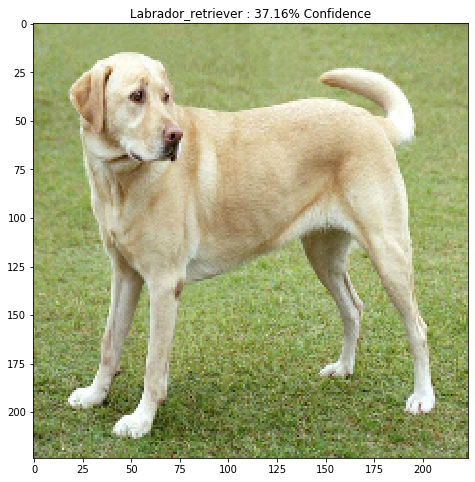

In [7]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the adversarial image

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [8]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adverserial(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
        
    # Get the gradients of the loss  w.r.t to the input image
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


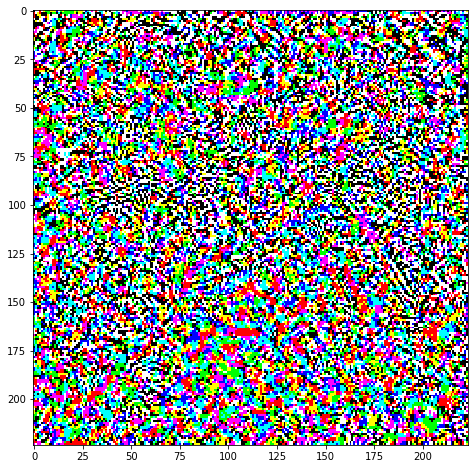

In [9]:
# Get the input label of image
labrador_retriver_index = 208
label = tf.one_hot(labrador_retriver_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adverserial(image, label)
plt.imshow(perturbations[0])

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [10]:
def display_images(image, description):
    _, label, confidence = get_imagenet_label(model.predict(image))
    plt.figure()
    plt.imshow(image[0])
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
    plt.show()

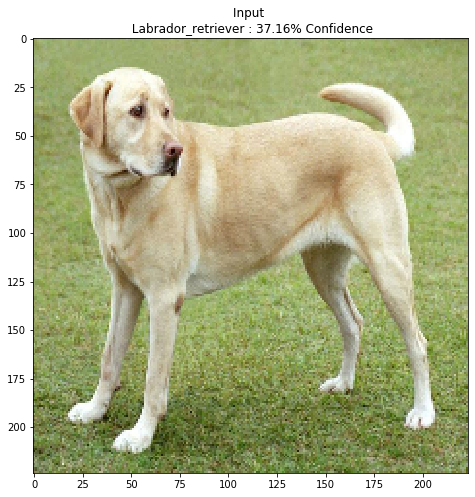

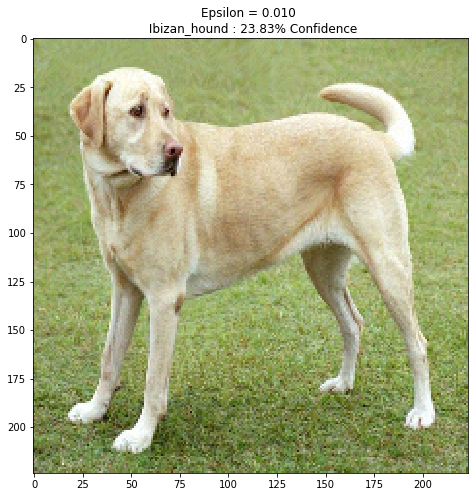

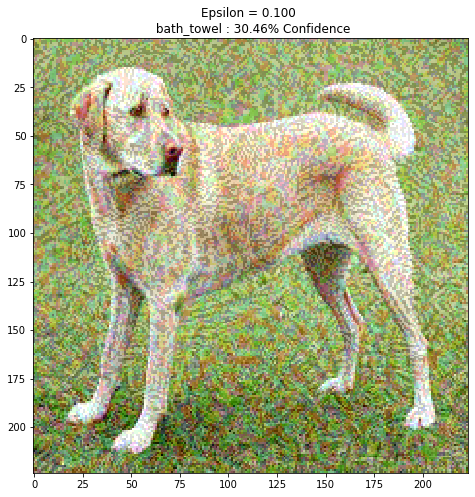

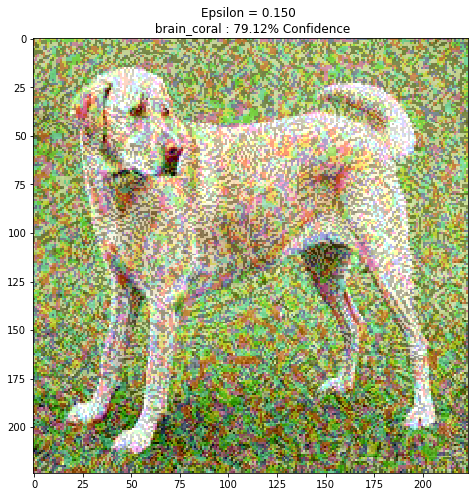

In [11]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i])